In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import ast
from model_din import DinWithoutCat, DinAir, DinPro
from tqdm import trange, tqdm



import pandas as pd
import torch
from torch.utils.data import IterableDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import wandb
from sklearn.metrics import accuracy_score

import logging
import math



In [ ]:
import json

game_cat_map = {}
for key, value in json.load(open('small_10/game_tags_mapping.json', 'r')).items():
    game_cat_map[int(key)] = torch.zeros(442, dtype=torch.int).scatter(0, torch.tensor(value, dtype=torch.long), 1)
print("Game category map loaded.")



class StreamingDataset(IterableDataset):
    def __init__(self, file_path, chunksize=128, transform=None):
        """
        :param file_path: data file path
        :param chunksize: chunk size for reading the file
        :param transform: function to transform the data
        """
        self.file_path = file_path
        self.chunksize = chunksize
        self.transform = transform
            

    def __iter__(self):
        for chunk in pd.read_csv(
            self.file_path,
            chunksize=self.chunksize
        ):
            for _, row in chunk.iterrows():
                sample = row.to_dict()
                if self.transform:
                    sample = self.transform(sample)
                yield sample




def transform_fn_din_air(sample):
    result = {}
    result['user_id'] = torch.tensor(sample['user_id'], dtype=torch.int)
    result['game_id'] = torch.tensor(sample['game_id'], dtype=torch.int)
    
    result['game_cats'] = game_cat_map.get(sample['game_id'], torch.zeros(442, dtype=torch.int))

    game_history_seq = torch.tensor(ast.literal_eval(sample['game_history']), dtype=torch.int)
    result['game_history'] = game_history_seq

    game_history_cats_list = []
    for game in game_history_seq.tolist():
        game_history_cats_list.append(game_cat_map.get(game, torch.zeros(442, dtype=torch.int)))
    result['game_history_cats'] = torch.stack(game_history_cats_list)
    
    result['num_features'] = torch.tensor([
        sample['num_feature1'],
        sample['num_feature2'],
        sample['num_feature3'],
        sample['num_feature4']
    ], dtype=torch.float)
    
    if "label" in sample:
        result['label'] = torch.tensor(sample['label'], dtype=torch.long).float()
    return result




def collate_fn_din_air(batch, max_hist_len=256):
    """
    Dynamic padding for batch data according to the maximum length of the history.
    """
    user_ids      = torch.stack([sample['user_id'] for sample in batch])
    item_ids      = torch.stack([sample['game_id'] for sample in batch])
    item_cats     = torch.stack([sample['game_cats'] for sample in batch])
    num_features  = torch.stack([sample['num_features'] for sample in batch])
    labels        = torch.stack([sample['label'] for sample in batch]) if "label" in batch[0] else None

    orig_lengths = [sample['game_history'].size(0) for sample in batch]
    target_seq_len = min(max(orig_lengths), max_hist_len)
    
    
    histories = [
        sample['game_history'][-target_seq_len:] if sample['game_history'].size(0) > target_seq_len 
        else sample['game_history']
        for sample in batch
    ]
    # in case the padded value collides with the actual data 0, first use NaN to pad
    histories = [h.float() for h in histories]
    # （padding_value = NaN）
    padded_histories = torch.nn.utils.rnn.pad_sequence(histories, batch_first=True, padding_value=float('nan'))
    # generate mask on NaN values
    seq_masks = torch.isnan(padded_histories)
    # replace NaN with 0
    padded_histories = torch.nan_to_num(padded_histories, nan=0).long()
    
    histories_cats = [
        sample['game_history_cats'][-target_seq_len:] if sample['game_history_cats'].size(0) > target_seq_len 
        else sample['game_history_cats']
        for sample in batch
    ]
    padded_hist_cats = torch.nn.utils.rnn.pad_sequence(histories_cats, batch_first=True, padding_value=0)
    
    
    return {
        'user_ids':           user_ids.long(),
        'item_ids':           item_ids.long(),
        'item_cats':          item_cats.float(),
        'item_num_features':  num_features,
        'hist_item_ids':      padded_histories.long(),      # [B, T]
        'hist_item_cats':     padded_hist_cats.float(),       # [B, T, 442]
        'seq_mask':           seq_masks,                    # [B, T]
        'labels':             labels.float() if labels is not None else None
    }

Game category map loaded.


In [ ]:
if __name__ == "__main__":

    # total_len = 11076267
    test_dataset = StreamingDataset('../small_10/local_test_mapped', chunksize=4096, transform=transform_fn_din_air)
    test_dataloader = DataLoader(test_dataset, batch_size=512, collate_fn=collate_fn_din_air)

    model = DinPro(
        user_num=274003,
        item_num=18369,
        cat_num=442,
        num_feature_size=4,
        hidden_size=64,
        num_heads=2
    )
    params_path = "../models/din_pro.pt"
    model.load_state_dict(torch.load(params_path))


    optimizer = optim.AdamW(model.parameters(), lr=1e-4)
    criterion = nn.BCEWithLogitsLoss()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    model.to(device)
    wandb.init(project="si699_proj", name="run")

    num_epochs = 10
    global_step = 0
    total_train_len = 11076267



    model.eval()
    all_preds = []
    all_labels = []


    with torch.no_grad():
        for data in tqdm(test_dataloader, desc="Evaluating", leave=False):
            user_ids         = data['user_ids'].to(device)         # [B]
            item_ids         = data['item_ids'].to(device)         # [B]
            item_cats        = data['item_cats'].to(device)        # [B, N]
            item_num_features= data['item_num_features'].to(device)  # [B, F]
            hist_item_ids    = data['hist_item_ids'].to(device)    # [B, T]
            hist_item_cats   = data['hist_item_cats'].to(device)   # [B, T, N]
            seq_mask         = data['seq_mask'].to(device)         # [B, T]
            label            = data['labels'].to(device).float()

            y_pred = model(
                user_ids,
                item_ids,
                item_cats,
                item_num_features,
                hist_item_ids,
                hist_item_cats,
                seq_mask
            )
            y_pred = torch.sigmoid(y_pred)

            preds = y_pred.squeeze().cpu().numpy()
            labels = label.long().cpu().numpy()

            all_preds.extend(preds.tolist())
            all_labels.extend(labels.tolist())


Using device: cuda


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: uso_tsuki to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [6]:
import numpy as np
import pandas as pd

eval_results = pd.DataFrame({
    "probability": all_preds,
    "label": all_labels
})
eval_results.to_csv("din_pro_eval_results.csv", index=False)

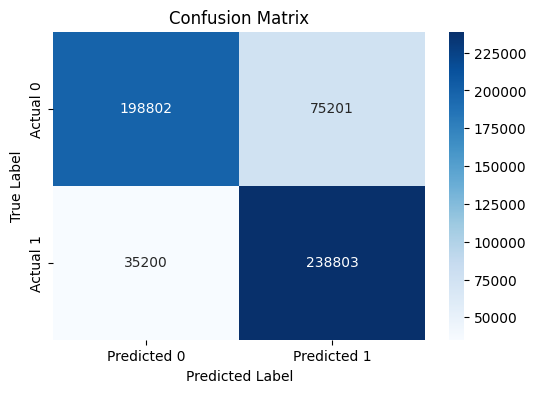

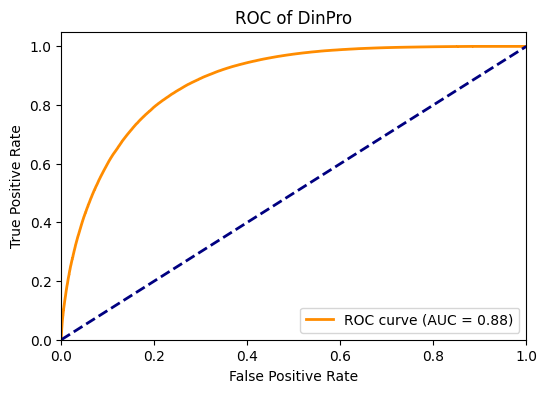

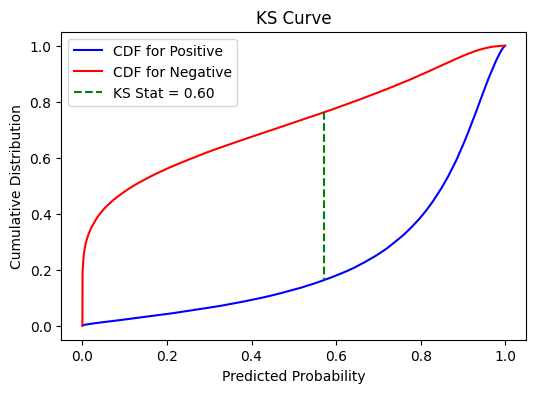

C:\Users\19441\AppData\Local\Temp\ipykernel_2084\1422867533.py:87: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")


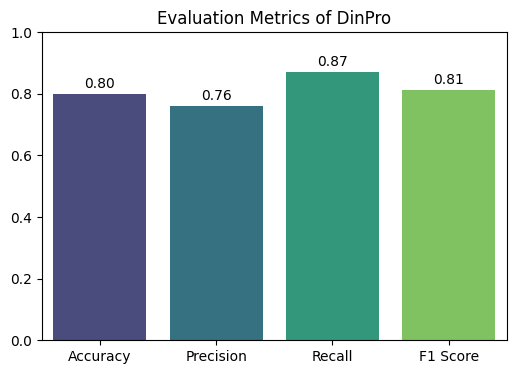

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import (confusion_matrix, roc_curve, auc, 
                             accuracy_score, precision_score, recall_score, f1_score)

# 1. 读取 CSV 数据（无表头，第一列为预测概率，第二列为真实标签）
data = pd.read_csv('din_pro_eval_results.csv')

# 2. 根据阈值（0.5）将概率转换为预测标签
threshold = 0.5
data['predicted'] = (data['probability'] >= threshold).astype(int)

# 3. 计算混淆矩阵，并绘制
cm = confusion_matrix(data['label'], data['predicted'])
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# 4. 计算 ROC 曲线和 AUC 值，并绘制 ROC 曲线
fpr, tpr, roc_thresholds = roc_curve(data['label'], data['probability'])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of DinPro')
plt.legend(loc="lower right")
plt.show()

# 5. 绘制 KS 曲线
# 分别计算正例和负例的预测概率累计分布
preds_positive = data[data['label'] == 1]['probability'].sort_values().values
preds_negative = data[data['label'] == 0]['probability'].sort_values().values

cdf_positive = np.arange(1, len(preds_positive) + 1) / len(preds_positive)
cdf_negative = np.arange(1, len(preds_negative) + 1) / len(preds_negative)

plt.figure(figsize=(6, 4))
plt.plot(preds_positive, cdf_positive, label='CDF for Positive', color='blue')
plt.plot(preds_negative, cdf_negative, label='CDF for Negative', color='red')

# 在一个共同的网格上计算两个 CDF 的插值
all_preds_sorted = np.sort(data['probability'].values)
cdf_pos_interp = np.interp(all_preds_sorted, preds_positive, cdf_positive)
cdf_neg_interp = np.interp(all_preds_sorted, preds_negative, cdf_negative)

# KS统计量：两个累计分布函数的最大绝对差
ks_stat = np.max(np.abs(cdf_pos_interp - cdf_neg_interp))
ks_index = np.argmax(np.abs(cdf_pos_interp - cdf_neg_interp))
ks_x = all_preds_sorted[ks_index]
ks_y_pos = cdf_pos_interp[ks_index]
ks_y_neg = cdf_neg_interp[ks_index]

plt.vlines(ks_x, ks_y_neg, ks_y_pos, colors='green', linestyles='dashed', label=f'KS Stat = {ks_stat:.2f}')
plt.xlabel('Predicted Probability')
plt.ylabel('Cumulative Distribution')
plt.title('KS Curve')
plt.legend(loc='best')
plt.show()

# 6. 计算 Accuracy, Precision, Recall, F1 Score
accuracy = accuracy_score(data['label'], data['predicted'])
precision = precision_score(data['label'], data['predicted'])
recall = recall_score(data['label'], data['predicted'])
f1 = f1_score(data['label'], data['predicted'])

metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1
}

# 绘制指标柱状图
plt.figure(figsize=(6, 4))
sns.barplot(x=list(metrics.keys()), y=list(metrics.values()), palette="viridis")
plt.ylim(0, 1)
plt.title('Evaluation Metrics of DinPro')
for i, v in enumerate(metrics.values()):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()
